![Logo AIED26](../assets/logo_AIED26.png)

# **Notebook#04 : Analysis on RQ3**
## [students' perception of the digital assistant]

## 1/ Imports

In [1]:
# Internal
import sys
sys.path.append("../src")
import students_constants as stu_const
import interaction_constants as int_const
import tests_constants  as tes_const
import session_date_constants as ses_const

# External
import pandas as pd
import xml.etree.ElementTree as ET
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats



## 2/ Data importation

In [2]:
interaction_data = pd.read_pickle("../data/interim/interaction_data.pkl")
pre_test_data = pd.read_pickle("../data/interim/pre_test_data.pkl")
post_test_data = pd.read_pickle("../data/interim/post_test_data.pkl")

## 3/ Students' perception of the digital assistant [B/C]

What is student perception of the assistant helps depending of groups ?

In [3]:
# Columns of questions to analyze (from _QA to _QE)
question_cols = tes_const.ASSISTANT_NUM_QUESTIONS

# Mapping of question keys to plain text question
QUESTION_MAPPING = {
    tes_const.QA_KEY: "Did you find the assistant help useful to progress in the game?",
    tes_const.QB_KEY: "Did you find the assistant help useful to learn Python programming?",
    tes_const.QD_KEY: "Did you find the assistant help easy to understand?",
    tes_const.QE_KEY: "Did you find that the assistant help was correct (without errors)?",
    tes_const.QC_KEY: "Would you like to have more help from a digital assistant in the future?"
}

group_col=tes_const.GROUP_ID_KEY
# Filter only groups B and C
df_filtered = post_test_data[post_test_data[group_col].isin([tes_const.GROUP_B, tes_const.GROUP_C])].copy()

# Dictionary to store results
stats_dict = {}

# Loop over each question
for q in question_cols:
    # Get data for both groups
    calls_B = df_filtered[df_filtered[group_col] == tes_const.GROUP_B][q].dropna()
    calls_C = df_filtered[df_filtered[group_col] == tes_const.GROUP_C][q].dropna()
    
    # Descriptive statistics
    mean_B, std_B = calls_B.mean(), calls_B.std()
    mean_C, std_C = calls_C.mean(), calls_C.std()
    n_B, n_C = len(calls_B), len(calls_C)
    
    print(f"\n######## {q} : {QUESTION_MAPPING[q]} ########")
    print("=== DESCRIPTIVE STATISTICS ===")
    print(f"Group B (n={n_B}): M = {mean_B:.2f}, SD = {std_B:.2f}")
    print(f"Group C (n={n_C}): M = {mean_C:.2f}, SD = {std_C:.2f}")
    
    # Normality tests (Shapiro-Wilk)
    shapiro_B = stats.shapiro(calls_B) if n_B >= 3 else None
    shapiro_C = stats.shapiro(calls_C) if n_C >= 3 else None
    
    alpha = 0.05
    print("\n=== NORMALITY TESTS (Shapiro-Wilk) ===")
    if shapiro_B and shapiro_C:
        print(f"Group B: p-value = {shapiro_B.pvalue:.4f} -> {'normally distributed' if shapiro_B.pvalue >= alpha else 'not normally distributed'}")
        print(f"Group C: p-value = {shapiro_C.pvalue:.4f} -> {'normally distributed' if shapiro_C.pvalue >= alpha else 'not normally distributed'}")
        normal_B, normal_C = shapiro_B.pvalue >= alpha, shapiro_C.pvalue >= alpha
    else:
        # Not enough data for Shapiro test
        print("Not enough data for Shapiro-Wilk test")
        normal_B, normal_C = False, False
    
    # Levene test for equal variances
    if n_B > 1 and n_C > 1:
        levene_p = stats.levene(calls_B, calls_C).pvalue
        equal_var = levene_p >= alpha
        print(f"\n=== HOMOGENEITY OF VARIANCES (Levene) ===")
        print(f"Levene p-value = {levene_p:.4f} -> {'variances are similar' if equal_var else 'variances differ'}")
    else:
        equal_var = False
        print("\nNot enough data for Levene test")
    
    # Choose statistical test
    print(f"\n=== STATISTICAL TEST ===")
    if normal_B and normal_C and equal_var:
        print("Using independent t-test (parametric)")
        stat, p_value = stats.ttest_ind(calls_B, calls_C, equal_var=True)
        # Cohen's d
        pooled_std = np.sqrt(((n_B - 1)*std_B**2 + (n_C - 1)*std_C**2) / (n_B + n_C - 2))
        effect_size = (mean_B - mean_C) / pooled_std
        effect_type = "Cohen's d"

    else:
        print("Using Mann-Whitney U test (non-parametric)")
        stat, p_value = stats.mannwhitneyu(calls_B, calls_C, alternative='two-sided')
        # Effect size r = Z / sqrt(N)
        n_total = n_B + n_C
        z_score = stats.norm.ppf(1 - p_value/2)  # convert two-sided p-value to Z
        effect_size = abs(z_score) / np.sqrt(n_total)
        effect_type = "r"

    print(f"Test statistic = {stat:.4f}")
    print(f"P-value = {p_value:.4f}")
    print(f"Effect size ({effect_type}) = {effect_size:.4f}")
    
    # Interpret effect size
    if effect_type == "Cohen's d":
        if abs(effect_size) < 0.2:
            label = "negligible"
        elif abs(effect_size) < 0.5:
            label = "small"
        elif abs(effect_size) < 0.8:
            label = "medium"
        else:
            label = "large"
    else:  # r
        if effect_size < 0.1:
            label = "negligible"
        elif effect_size < 0.3:
            label = "small"
        elif effect_size < 0.5:
            label = "medium"
        else:
            label = "large"
    
    print(f"Effect size interpretation: {label}")

    if p_value < alpha:
        print(f"SIGNIFICANT difference: p = {p_value:.4f} < {alpha}")
    else:
        print(f"No significant difference: p = {p_value:.4f} >= {alpha}")
    
    # Store results in dictionary
    stats_dict[q] = {
        "mean_B": mean_B,
        "std_B": std_B,
        "mean_C": mean_C,
        "std_C": std_C,
        "significant": p_value < alpha
    }



######## _QA : Did you find the assistant help useful to progress in the game? ########
=== DESCRIPTIVE STATISTICS ===
Group B (n=91): M = 65.32, SD = 25.21
Group C (n=72): M = 59.58, SD = 25.22

=== NORMALITY TESTS (Shapiro-Wilk) ===
Group B: p-value = 0.0008 -> not normally distributed
Group C: p-value = 0.0371 -> not normally distributed

=== HOMOGENEITY OF VARIANCES (Levene) ===
Levene p-value = 0.8297 -> variances are similar

=== STATISTICAL TEST ===
Using Mann-Whitney U test (non-parametric)
Test statistic = 3716.5000
P-value = 0.1410
Effect size (r) = 0.1153
Effect size interpretation: small
No significant difference: p = 0.1410 >= 0.05

######## _QB : Did you find the assistant help useful to learn Python programming? ########
=== DESCRIPTIVE STATISTICS ===
Group B (n=91): M = 65.56, SD = 24.39
Group C (n=72): M = 65.24, SD = 26.33

=== NORMALITY TESTS (Shapiro-Wilk) ===
Group B: p-value = 0.0029 -> not normally distributed
Group C: p-value = 0.0002 -> not normally distribute

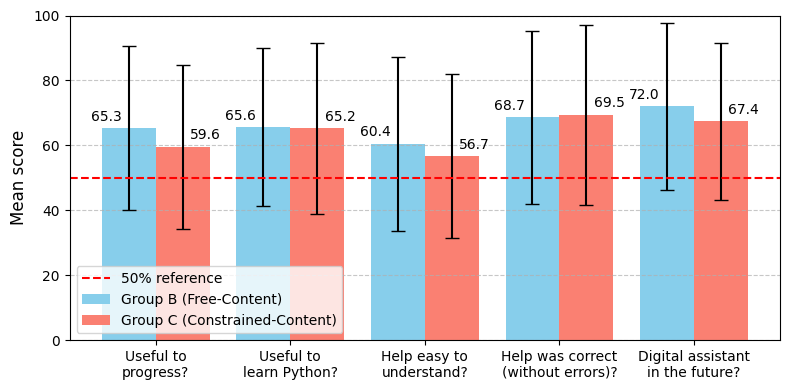

In [4]:
# Mapping of question keys to English question text
QUESTION_DISPLAY = {
    tes_const.QA_KEY: "Useful to\nprogress?",
    tes_const.QB_KEY: "Useful to\nlearn Python?",
    tes_const.QD_KEY: "Help easy to\nunderstand?",
    tes_const.QE_KEY: "Help was correct\n(without errors)?",
    tes_const.QC_KEY: "Digital assistant\nin the future?"
}

# Use previously computed stats_dict
summary_list = []
for q in question_cols:
    stats_q = stats_dict[q]  # fetch stored results
    
    summary_list.append({
        'question': q,
        'question_text': QUESTION_DISPLAY[q],
        'mean_B': stats_q['mean_B'],
        'std_B': stats_q['std_B'],
        'mean_C': stats_q['mean_C'],
        'std_C': stats_q['std_C'],
        'significant': stats_q['significant']
    })

summary_df = pd.DataFrame(summary_list)

# Parameters for side-by-side bar chart
x = np.arange(len(summary_df))
width = 0.40

# Create figure and axes
fig, ax = plt.subplots(figsize=(8, 4))

# Plot bars with error bars
bars_B = ax.bar(x - width/2, summary_df['mean_B'], width, yerr=summary_df['std_B'], capsize=5, label='Group B (Free-Content)', color='skyblue')
bars_C = ax.bar(x + width/2, summary_df['mean_C'], width, yerr=summary_df['std_C'], capsize=5, label='Group C (Constrained-Content)', color='salmon')

# Set x-axis labels
ax.set_xticks(x)
# ax.set_xticklabels(summary_df['question_text'], rotation=25, ha='right', fontsize=10)
ax.set_xticklabels(summary_df['question_text'], ha='center', fontsize=10)


# Add axis labels and title
# ax.set_xlabel("Question", fontsize=12)
ax.set_ylabel("Mean score", fontsize=12)
# Add horizontal dashed line at 50%
ax.axhline(y=50, color='red', linestyle='--', linewidth=1.5, label='50% reference')

ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_ylim(0, 100)

# Annotate significance and values above bars
for i, row in summary_df.iterrows():
    # Position for significance star
    y_star = max(row['mean_B'], row['mean_C']) + max(row['std_B'], row['std_C']) * 0.1
    if row['significant']:
        ax.text(i, y_star, '*', ha='center', va='bottom', fontsize=16, color='black')

    # Add values above each bar (just above the bar, ignoring SD)
    offset = 1.4  # small vertical margin above the bar
    dx_b = 0.17   # horizontal shift (can adjust if needed)
    dx_c = -0.17  # horizontal shift (can adjust if needed)
    ax.text(i - width/2 - dx_b, row['mean_B'] + offset, f"{row['mean_B']:.1f}", ha='center', va='bottom', fontsize=10, color='black')
    ax.text(i + width/2 - dx_c, row['mean_C'] + offset, f"{row['mean_C']:.1f}", ha='center', va='bottom', fontsize=10, color='black')

# Add legend
ax.legend()

# Adjust layout, save figure, and display
plt.tight_layout()
plt.savefig("../outputs/assistance_perception_BC.png", dpi=300, bbox_inches="tight")
plt.show()
